In [296]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_columns', 100)

dfMain = pd.DataFrame.from_csv('data.csv')
print(dfMain.shape)
print(dfMain['combined_shot_type'].unique())
# dfMain['game_id'].plot()
# dfMain['game_event_id'].plot()
display(dfMain.head())

(30697, 24)
['Jump Shot' 'Dunk' 'Layup' 'Tip Shot' 'Hook Shot' 'Bank Shot']


,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
action_type,,,,,,,,,,,,,,,,,,,,,,,,
Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [297]:
# Reset index
dfMain = dfMain.reset_index(drop=True)

In [298]:
# Separate training/submit data
training_data = dfMain[~dfMain['shot_made_flag'].isnull()]
submit_data = dfMain[dfMain['shot_made_flag'].isnull()]

In [299]:
# Get validation/test data indices
submit_data_index = list(submit_data.index)
# Get rid of the first element
submit_data_index.pop(0)

validation_data_index = [x + 1 for x in submit_data_index if x + 1 not in submit_data_index]
test_data_index = [x + 2 for x in submit_data_index if x + 2 not in submit_data_index]

In [300]:
def split_features_labels(data):
    # Put labels at the end of columns
    label_index = data.columns.get_loc("shot_made_flag")
    column_list = list(data.columns)
    new_column_list = column_list[:label_index] + column_list[label_index+1:] + [column_list[label_index]]
    data = data[new_column_list]

    feature_data, label_data = data.ix[:, :-1], data.ix[:, -1]
    
    return feature_data, label_data

X_train, y_train = split_features_labels(training_data)
X_submit, _ = split_features_labels(submit_data)

In [301]:
def preprocess_feature_data(X_data):
    # Combine seconds_remaining with minutes_remaining
    X_data['secs_remaining'] = X_data['minutes_remaining'] * 60 + X_data['seconds_remaining']
    del X_data['minutes_remaining']
    del X_data['seconds_remaining']
    
    # Drop columns
    # Drop geographical info
    del X_data['lat']
    del X_data['lon']
    # Drop date info
    del X_data['game_date']
    # Drop matchup
    del X_data['matchup']
    # Drop shot_id
    del X_data['shot_id']
    # Drop team_name
    del X_data['team_name']
    # Drop team_id
    del X_data['team_id']
    
    # Discretize
    # shot_zone_range
    shot_zone_range_map = {'Less Than 8 ft.': 0, '8-16 ft.': 1, '16-24 ft.': 2, '24+ ft.': 3, 'Back Court Shot': 4}
    X_data = X_data.replace({'shot_zone_range': shot_zone_range_map})
    
    # One-hot encode categorical data
    X_data = pd.get_dummies(X_data)
    
    # Put playoffs at the end
    playoffs_index = X_data.columns.get_loc("playoffs")
    X_data_columns = list(X_data.columns)
    new_X_data_columns = X_data_columns[:playoffs_index] + X_data_columns[playoffs_index+1:] + [X_data_columns[playoffs_index]]
    X_data = X_data[new_X_data_columns]
    
    # Normalize non-sparse cols
    def normalize(df):
        return (df - np.min(df)) / (np.max(df) - np.min(df))

    X_data.ix[:, :8] = normalize(X_data.ix[:, :8])
    
    return X_data

In [302]:
# One-hot Encode
    # combine_shot_type (str)
    # season (str)
    # shot_type (str)
    # shot_zone_area (str)
    # shot_zone_basic (str)
    # opponent (str)

# Normalization
    # game_event_id (int)
    # game_id (int)
    # loc_x (int)
    # loc_y (int)
    # period (int)
    # shot_distance (int)
    # secs_remaining (int)

In [304]:
X_train = preprocess_feature_data(X_train)

0.949864895208
Fitting PCA took 0.35781121253967285 seconds


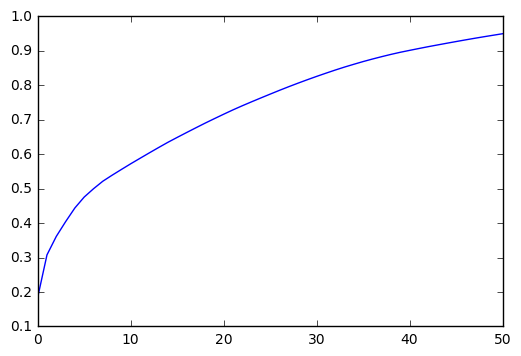

In [326]:
# Apply PCA to data to reduce dimensions
# Find best pca_dim
# PCA Fit and Transformation and DF Reconstruction
def pca_transform_reconstruct(fit_data, trans_data, pca_dim):
    start_time = time.time()
    
    pca = PCA(n_components=pca_dim)
    pca.fit(fit_data)

    data_pca = pca.transform(trans_data)
    data_pca = pd.DataFrame(data=data_pca)

    cp_imp = pca.explained_variance_ratio_
    cp_imp = pd.Series(cp_imp)
    cp_imp_cum = cp_imp.cumsum()
    cp_imp_cum.plot()
    print(cp_imp_cum.iloc[-1])
    print("Fitting PCA took {} seconds".format(time.time() - start_time))

    return data_pca

X_train_pca = pca_transform_reconstruct(X_train, X_train, 51)

In [328]:
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,-0.335940,-0.933455,-0.171003,-0.090233,-0.650317,-0.423378,0.272559,-0.696645,-0.250104,-0.018659,-0.107915,-0.139552,-0.064020,-0.009479,0.282739,0.225624,-0.402678,0.521752,0.163602,-0.227043,-0.395195,-0.143692,-0.182040,0.424851,0.614546,0.001751,-0.142020,-0.326427,-0.307022,-0.261003,-0.111292,-0.044310,-0.071939,-0.064100,0.005585,-0.096526,-0.058704,0.081311,-0.016174,0.112390,-0.029442,-0.079368,-0.113759,-0.017059,-0.060180,-0.009982,0.000566,-0.017075,-0.003407,-0.013427,-0.010753
1,-0.506746,-0.652698,-0.249129,-0.089819,-0.658687,0.177422,-0.809160,-0.183471,0.019576,-0.001822,0.091628,-0.240570,-0.112030,-0.138257,0.258002,0.271388,-0.443772,0.613620,0.143606,-0.205587,-0.373410,-0.116630,-0.183480,0.417940,0.593171,-0.011746,-0.120992,-0.327342,-0.279095,-0.265955,-0.110854,-0.033835,-0.087698,-0.062587,0.016652,-0.076173,-0.071296,0.076464,-0.023591,0.098781,-0.010370,0.112193,-0.015066,-0.003885,-0.084540,0.017196,-0.008903,-0.015450,0.002939,-0.017653,-0.012689
2,-0.550511,-0.669721,-0.345415,-0.209086,0.493764,-0.686674,-0.462655,-0.186991,-0.028597,0.012811,0.052980,-0.254688,-0.120391,-0.178110,0.234040,0.252343,-0.452192,0.600007,0.137233,-0.194698,-0.371134,-0.099075,-0.172331,0.418906,0.598462,-0.024322,-0.153342,-0.323206,-0.276765,-0.283952,-0.118979,-0.025753,-0.072705,-0.078657,0.016873,-0.075363,-0.072239,0.078284,-0.029237,0.094463,-0.013400,0.098685,-0.017746,-0.006620,-0.083407,0.021286,-0.006370,-0.018205,0.000283,-0.023916,-0.016617
3,1.274646,0.292098,-0.174200,-0.185658,-0.030964,-0.035771,-0.107456,-0.126455,-0.503758,0.014544,-0.072631,-0.169355,-0.134951,-0.094146,0.319145,0.531766,0.284462,1.100971,0.338174,-0.051987,-0.017809,-0.064598,-0.143274,0.321456,0.672623,0.020540,-0.120015,-0.329645,-0.335572,-0.308423,-0.207976,-0.059280,-0.093930,-0.055752,0.005528,-0.046857,-0.142998,0.073254,-0.005999,0.110204,-0.011255,0.003658,-0.073593,-0.010143,-0.059507,-0.007975,0.000662,-0.039891,0.002237,-0.009752,-0.015807
4,-0.343103,-0.910505,-0.168380,-0.091766,-0.652042,-0.412759,0.415928,-0.331018,-0.243211,0.012970,-0.013516,0.034814,0.025236,0.110335,0.425907,0.203607,-0.383480,0.537696,0.150551,-0.209707,-0.420501,-0.146672,-0.189514,0.416837,0.614192,-0.004169,-0.161772,-0.323695,-0.299673,-0.238193,-0.114684,-0.048389,-0.072361,-0.068561,0.002919,-0.077406,-0.071607,0.089808,-0.012188,0.109659,-0.033927,-0.082835,-0.112321,-0.019390,-0.055674,-0.004698,0.003051,-0.018766,-0.002946,-0.014515,-0.008746


In [332]:
from sklearn.linear_model import RandomizedLasso

names = list(X_train_pca.columns)

rlasso = RandomizedLasso(alpha='aic')
rlasso.fit(X_train_pca, y_train)
rlasso_ranking = sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), names), reverse=True)
print("Features sorted by their score:")
print(rlasso_ranking)

Features sorted by their score:
[(1.0, 36), (1.0, 35), (1.0, 28), (1.0, 26), (1.0, 20), (1.0, 19), (1.0, 18), (1.0, 17), (1.0, 16), (1.0, 15), (1.0, 7), (1.0, 6), (1.0, 2), (1.0, 0), (0.995, 24), (0.98999999999999999, 40), (0.98999999999999999, 30), (0.96499999999999997, 5), (0.95499999999999996, 4), (0.93999999999999995, 12), (0.93500000000000005, 48), (0.90500000000000003, 27), (0.88, 23), (0.81999999999999995, 22), (0.78500000000000003, 11), (0.755, 37), (0.745, 8), (0.72999999999999998, 34), (0.72499999999999998, 46), (0.69499999999999995, 25), (0.68999999999999995, 44), (0.68999999999999995, 29), (0.67500000000000004, 10), (0.61499999999999999, 41), (0.57499999999999996, 45), (0.51000000000000001, 14), (0.505, 38), (0.48999999999999999, 42), (0.48499999999999999, 9), (0.35999999999999999, 47), (0.34999999999999998, 3), (0.31, 21), (0.30499999999999999, 31), (0.29999999999999999, 32), (0.28499999999999998, 50), (0.28499999999999998, 13), (0.27500000000000002, 33), (0.26500000000000

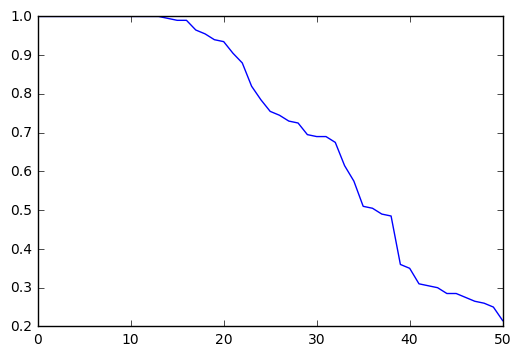

In [333]:
# 10 features before the drop
plt.plot([x[0] for i, x in enumerate(rlasso_ranking)])

In [306]:
X_validation = X_train.loc[validation_data_index, :]
X_test = X_train.loc[test_data_index, :]

print(X_validation.shape)
print(X_test.shape)

(4204, 83)
(4174, 83)


In [317]:
print(validation_data_index[:10])

[8, 17, 20, 38, 45, 50, 55, 60, 67, 71]


In [318]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def train_predict(X_train, y_train, val_data_index):
    start_time = time.time()

    pred_y_list = []
    counter = 0
    for i in val_data_index:
        X_batch = X_train.loc[:i-1, :]
        y_batch = y_train.loc[:i-1]

        clf = RandomForestClassifier(n_estimators=128, n_jobs=-1, random_state=42)
        clf.fit(X_batch, y_batch)

        X_val = X_train.loc[i, :].values.reshape(1, -1)

        pred_y = clf.predict(X_val)
        pred_y_list.append(pred_y)
        
        counter += 1
        print('Predicting ' + str(counter) + 'th row.')
        print(accuracy_score(y_train[validation_data_index][:counter], pred_y_list))
    print("Training took {} seconds.".format(time.time() - start_time))
    
    return pred_y_list

In [319]:
pred_y_list = train_predict(X_train, y_train, validation_data_index)

Predicting 1th row.
0.0
Predicting 2th row.
0.0
Predicting 3th row.
0.333333333333
Predicting 4th row.
0.25
Predicting 5th row.
0.4
Predicting 6th row.
0.333333333333
Predicting 7th row.
0.428571428571
Predicting 8th row.
0.5
Predicting 9th row.
0.555555555556
Predicting 10th row.
0.6
Predicting 11th row.
0.545454545455
Predicting 12th row.
0.5
Predicting 13th row.
0.538461538462
Predicting 14th row.
0.5
Predicting 15th row.
0.466666666667
Predicting 16th row.
0.5
Predicting 17th row.
0.470588235294
Predicting 18th row.
0.5
Predicting 19th row.
0.473684210526
Predicting 20th row.
0.5
Predicting 21th row.
0.47619047619
Predicting 22th row.
0.454545454545
Predicting 23th row.
0.434782608696
Predicting 24th row.
0.458333333333
Predicting 25th row.
0.44
Predicting 26th row.
0.423076923077
Predicting 27th row.
0.444444444444
Predicting 28th row.
0.428571428571
Predicting 29th row.
0.448275862069
Predicting 30th row.
0.466666666667
Predicting 31th row.
0.451612903226
Predicting 32th row.
0.4

1.0


In [312]:
X_train.iloc[:3, :]

,game_event_id,game_id,loc_x,loc_y,period,shot_distance,shot_zone_range,secs_remaining,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,season_1996-97,season_1997-98,season_1998-99,season_1999-00,season_2000-01,season_2001-02,season_2002-03,season_2003-04,season_2004-05,season_2005-06,season_2006-07,season_2007-08,season_2008-09,season_2009-10,season_2010-11,season_2011-12,season_2012-13,season_2013-14,season_2014-15,season_2015-16,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),shot_zone_basic_Above the Break 3,shot_zone_basic_Backcourt,shot_zone_basic_In The Paint (Non-RA),shot_zone_basic_Left Corner 3,shot_zone_basic_Mid-Range,shot_zone_basic_Restricted Area,shot_zone_basic_Right Corner 3,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,playoffs
1,0.015361,0.0,0.186747,0.052695,0.0,0.189873,0.25,0.871148,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0.050691,0.0,0.299197,0.214371,0.0,0.202532,0.50,0.651261,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0.062980,0.0,0.779116,0.262275,0.0,0.278481,0.50,0.577031,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
